In [1]:
from importlib import reload
from datetime import datetime
from my_functions import read_data
from my_functions import data_visualization as dv
from my_functions import my_svr
from my_functions import my_errors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
** A shopping center's elec data from 2017-1-15 to 2017-4-27 **

In [2]:
elec_data_path = './elec_data/hac.xlsx'
weather_data_path = './weather_data/weather_data_20170101-20170507_Shenzhen.csv'

elec = read_data.elec(elec_data_path, scale='H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')
elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,1245.15,82.0,13.0
2017-01-15 01:00:00,947.70,77.0,14.0
2017-01-15 02:00:00,864.60,77.0,14.0
2017-01-15 03:00:00,884.85,82.0,13.0
2017-01-15 04:00:00,838.20,88.0,13.0


** Check missing kwh data **

In [3]:
elec_and_weather[elec_and_weather.kwh.isnull()].index

DatetimeIndex(['2017-02-09 23:00:00', '2017-02-10 00:00:00',
               '2017-02-10 01:00:00', '2017-02-10 02:00:00',
               '2017-02-10 03:00:00', '2017-02-10 04:00:00',
               '2017-02-10 05:00:00', '2017-02-10 06:00:00',
               '2017-02-10 07:00:00', '2017-02-10 08:00:00'],
              dtype='datetime64[ns]', name='stat_time', freq='H')

# Some plots

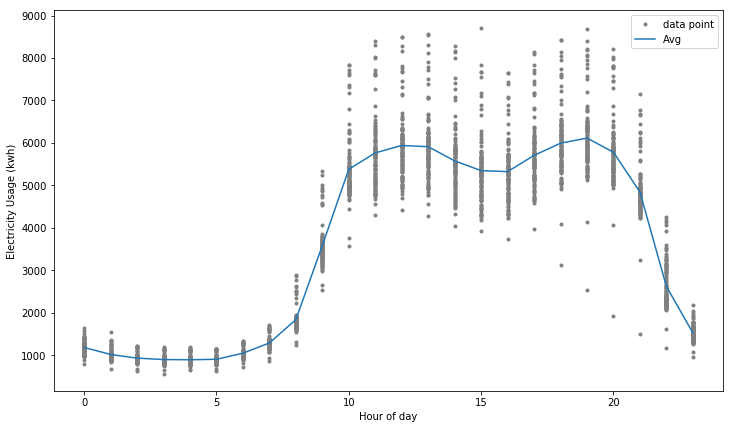

In [4]:
dv.plot_elec_hourly(elec_and_weather)

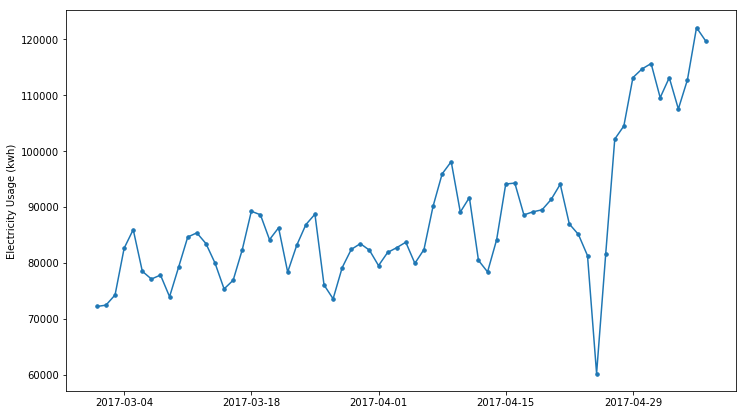

In [5]:
dv.plot_elec_daily(elec_and_weather['2017/3/1':])

significan difference since 4/27, maybe the shopping mall start to use AC

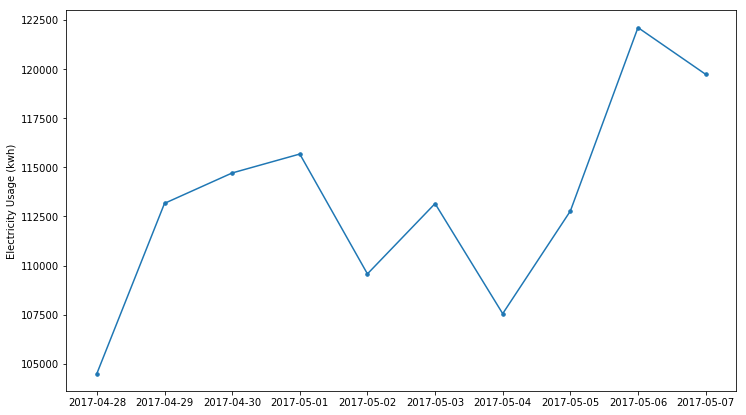

In [6]:
dv.plot_elec_daily(elec_and_weather['2017/4/28':])

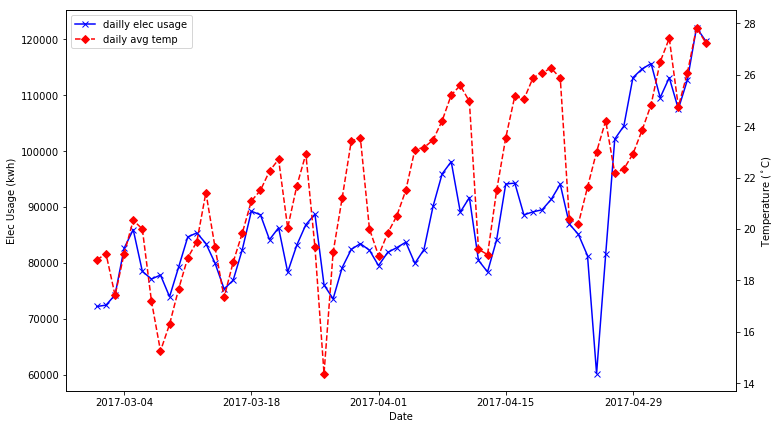

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 7))
l1 = ax1.plot(elec_and_weather['2017/3/1':].resample('D').sum().kwh, 'b-', marker='x')
ax1.set_xlabel('Date')
ax1.set_ylabel('Elec Usage (kwh)')
ax2 = ax1.twinx()
l2 = ax2.plot(weather['2017/3/1':].resample('D').mean().tempm, color='r', linestyle='--', marker='D')
ax2.set_ylabel('Temperature ($^\circ$C)')
ax1.legend([l1[0], l2[0]], ('dailly elec usage', 'daily avg temp'), loc='upper left')

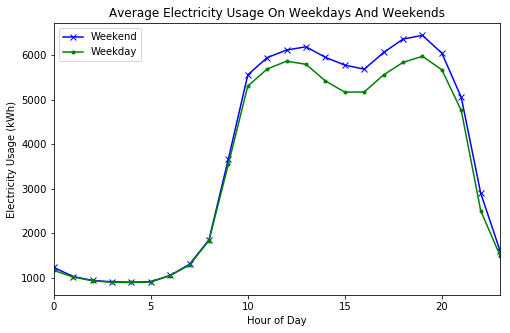

In [8]:
dv.compare_weekday_weekend(elec_and_weather)

                            OLS Regression Results                            
Dep. Variable:                    kwh   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     467.8
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           8.47e-96
Time:                        21:03:43   Log-Likelihood:                -24473.
No. Observations:                2702   AIC:                         4.895e+04
Df Residuals:                    2700   BIC:                         4.896e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -565.4374    195.187     -2.897      0.0

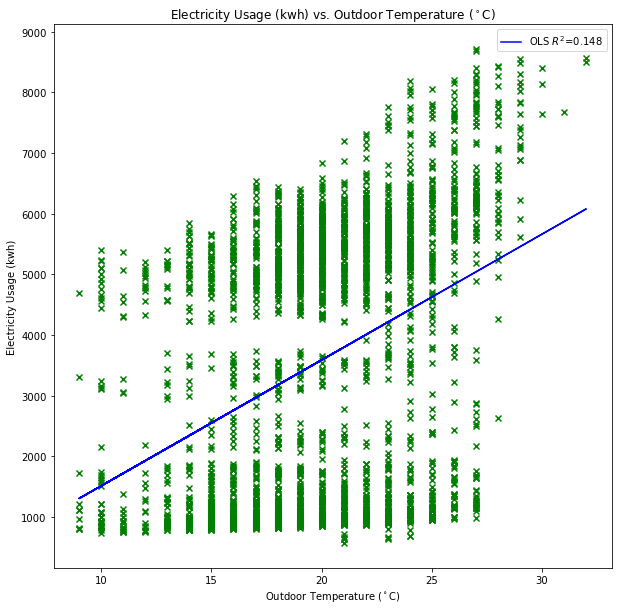

In [9]:
dv.compare_elec_temp(elec_and_weather.dropna(), if_ols=True)

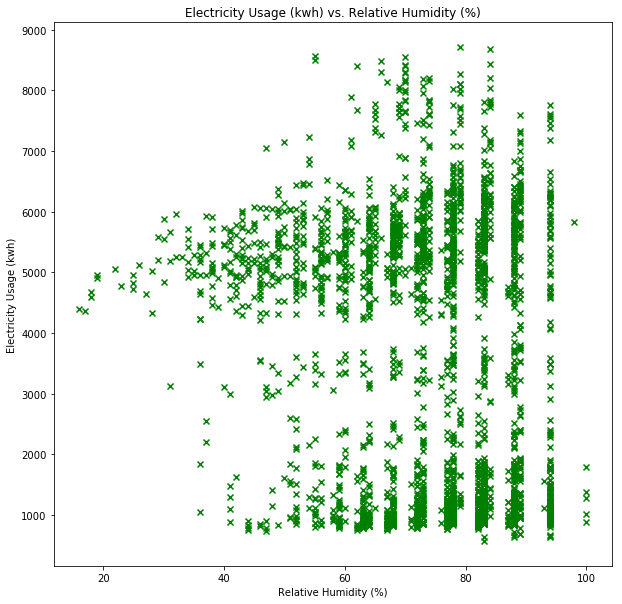

In [10]:
dv.compare_elec_hum(elec_and_weather.dropna())

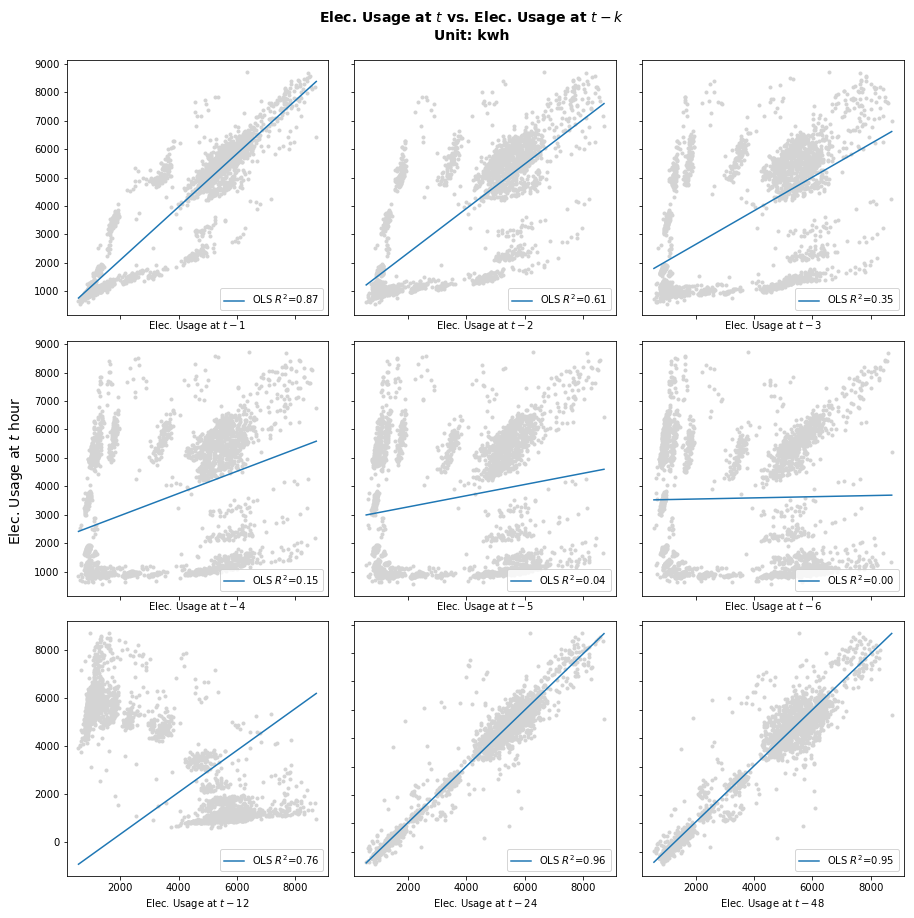

In [10]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather.dropna())

# First Time SVR

add features

In [11]:
holidays=['2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '4/3/2017', '4/4/2017', '5/1/2017']
workdays=['4/1/2017']
split_date = ['1/17/2017', '4/27/2017', '4/28/2017', '5/2/2017', '5/3/2017', '5/7/2017']
cross_set_dates = ['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02']
test_set_dates = ['2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07']

In [12]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_1h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head()

,hum,tempm,kwh_t-1,kwh_t-24,if_holiday,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-01-17 00:00:00,82.0,15.0,1417.65,1073.10,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 01:00:00,94.0,14.0,1145.10,986.85,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 02:00:00,88.0,15.0,926.40,870.00,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 03:00:00,88.0,15.0,898.50,868.65,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 04:00:00,82.0,15.0,842.70,851.40,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

{'RMSE': 953.55685053789807, 'MAE': 737.2766175032887, 'MAPE': 13.803326462276694}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-04-28,549.487083,10.807345,699.882634,104500.295573,91823.941649,-12.130448
2017-04-29,832.071798,13.492187,1061.244654,113165.896354,94270.284995,-16.697267
2017-04-30,816.117054,15.863136,1008.366148,114713.716667,98569.970576,-14.073074
2017-05-01,881.764310,16.116010,1137.334196,115678.008073,98741.389010,-14.641175
2017-05-02,606.942843,12.737955,787.366533,109573.267708,98169.163193,-10.407743


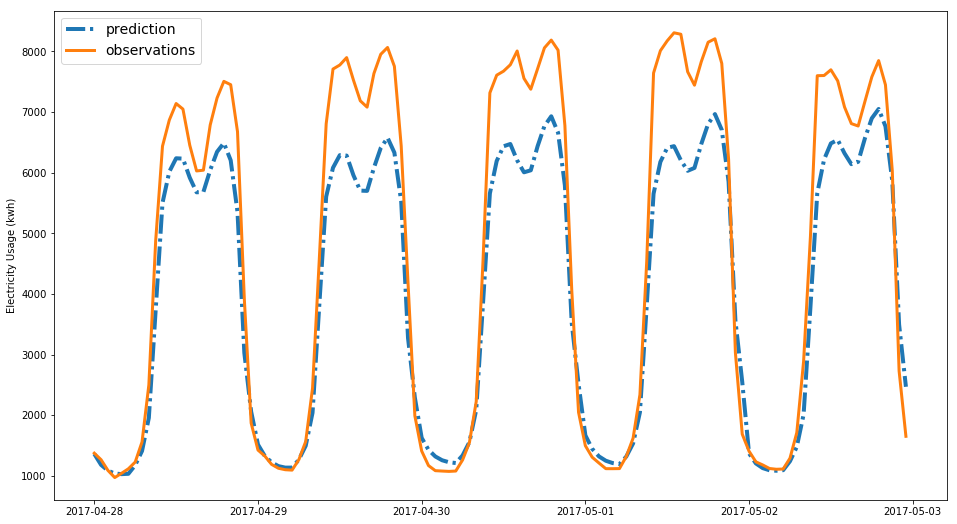

In [14]:
model = svm.SVR(kernel='linear', C=100).fit(df_X_train_scaled, y_train)
result, df_err = my_svr.predict_many_days(model, scaler, df_X_cross_scaled, y_cross,
                                          cross_set_dates, scale='H')
dv.plot_pred(y_cross, result)
df_err

# Grid Search

In [15]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [16]:
search_result['linear']

C,1,10,100,1000
MAE,652.504172,606.562922,737.276618,803.213045
MAPE,11.217045,11.300751,13.803326,14.773680
RMSE,849.958746,783.007649,938.838833,1018.454516


In [17]:
search_result['rbf']

MAE                                               MAPE  \
C              1            10           100          1000        1      
gamma                                                                    
0.0001  2815.852645  2805.816154  2711.516200  1617.240585  108.410796   
0.0005  2811.507727  2764.974364  2251.171446   655.436295  108.254117   
0.001   2806.313712  2716.298750  1674.283372   620.667105  108.066211   
0.005   2775.346296  2371.790290   707.068495   611.526285  106.391962   
0.01    2752.470998  2105.718479   711.065846   655.372831  104.933239   
0.05    2751.363528  2099.997039  1009.760864   823.672190  103.992153   
0.1     2775.088827  2365.322709  1223.636767   927.484645  105.403179   
0.5     2808.465145  2740.162803  1961.790601  1254.657876  107.998048   
auto    2739.885005  1966.966525   892.930576   772.673732  103.504722   

                                                  RMSE               \
C             10          100        1000         1            10     
gamma                                                                 
0.0001  108.049520  102.809955  55.696593  2954.607171  2943.999454   
0.0005  105.860170   84.493791  11.276699  2950.015616  2902.749775   
0.001   103.052946   58.300613  11.114241  2944.527964  2854.452623   
0.005    89.173181   12.195810  12.045341  2913.264432  2493.324176   
0.01     76.870531   12.766577  13.011821  2890.876928  2224.534872   
0.05     71.262805   18.711356  16.841397  2892.338006  2252.050731   
0.1      82.842629   22.289427  18.623144  2915.692395  2515.678654   
0.5     102.164386   47.852199  22.398075  2947.458158  2884.551689   
auto     66.327710   16.573638  15.754127  2880.509862  2114.543812   

                                  
C              100          1000  
gamma                             
0.0001  2849.626534  1734.877290  
0.0005  2367.442279   853.068547  
0.001   1790.677263   802.557865  
0.005    914.960503   767.313620  
0.01     907.878738   817.058448  
0.05    1264.802461  1004.703268  
0.1     1536.791120  1129.391975  
0.5     2336.315383  1607.528069  
auto    1122.564854   946.337182

In [18]:
search_result['poly']

MAE                                              MAPE  \
C              1            10           100         1000        1      
degree                                                                  
2       2764.666285  2266.078982  1217.347720  795.675470  104.575887   
3       2758.258828  2185.589868   853.494817  625.122870  104.651374   
4       2766.480917  2274.739962   845.990297  665.691902  105.218995   
5       2770.334279  2315.819972   773.837463  563.810080  105.601839   
6       2774.164154  2356.361291   708.494334  524.901357  105.944095   
7       2777.295182  2389.559363   646.999698  543.291167  106.233897   

                                                RMSE               \
C            10         100        1000         1            10     
degree                                                              
2       78.190133  23.578946  19.948057  2905.320864  2415.775178   
3       76.811773  16.079077  13.471225  2897.584170  2319.363688   
4       81.333182  15.754780  14.271755  2905.481210  2404.676643   
5       83.889057  14.006094  12.407567  2908.834034  2441.527677   
6       86.399616  12.491592  11.358208  2912.305967  2479.139045   
7       88.718157  11.581235  11.130524  2915.124436  2509.377023   

                                 
C              100         1000  
degree                           
2       1485.909955  934.127260  
3       1063.813120  774.888160  
4       1058.718050  816.428818  
5        983.034866  718.769686  
6        916.481964  682.531135  
7        851.810719  704.658302

# Final test

{'RMSE': 692.37922191606651, 'MAE': 511.1826638696123, 'MAPE': 10.589649234775116}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,411.197788,9.726935,507.998404,113154.983854,103286.236933,-8.721443
2017-05-04,325.377186,8.484074,431.293110,107548.491406,99857.464161,-7.151218
2017-05-05,520.242960,11.096285,668.615238,112773.778906,100287.947875,-11.071573
2017-05-06,866.238387,14.887147,1085.335181,122118.200521,101328.479231,-17.024261
2017-05-07,432.856999,8.753805,572.599351,119738.961979,109892.673928,-8.223128


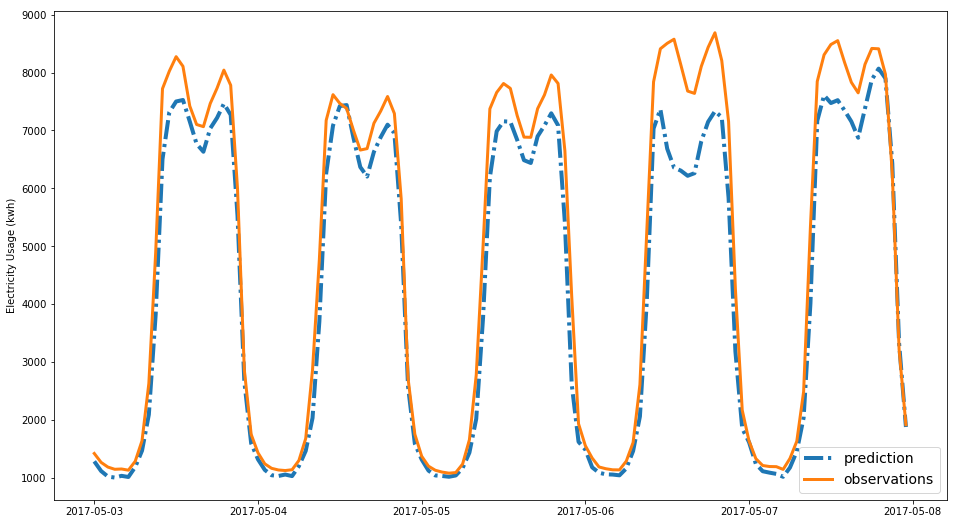

In [19]:
final_model = svm.SVR(kernel='poly', C=1000, degree=6).fit(df_X_train_scaled, y_train)
result_1h, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_1h,
                                          test_set_dates, scale='H')
dv.plot_pred(y_test_1h, result_1h)
df_err

# half hour prediction

In [20]:
elec = read_data.elec(elec_data_path, scale='30min')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,661.95,82.0,13.0
2017-01-15 00:30:00,583.20,NaN,NaN
2017-01-15 01:00:00,488.10,77.0,14.0
2017-01-15 01:30:00,459.60,NaN,NaN
2017-01-15 02:00:00,434.40,77.0,14.0


In [21]:
elec_and_weather[elec_and_weather.kwh.isnull()].index

DatetimeIndex(['2017-02-09 23:00:00', '2017-02-09 23:30:00',
               '2017-02-10 00:00:00', '2017-02-10 00:30:00',
               '2017-02-10 01:00:00', '2017-02-10 01:30:00',
               '2017-02-10 02:00:00', '2017-02-10 02:30:00',
               '2017-02-10 03:00:00', '2017-02-10 03:30:00',
               '2017-02-10 04:00:00', '2017-02-10 04:30:00',
               '2017-02-10 05:00:00', '2017-02-10 05:30:00',
               '2017-02-10 06:00:00', '2017-02-10 06:30:00',
               '2017-02-10 07:00:00', '2017-02-10 07:30:00',
               '2017-02-10 08:00:00', '2017-02-10 08:30:00'],
              dtype='datetime64[ns]', name='stat_time', freq='30T')

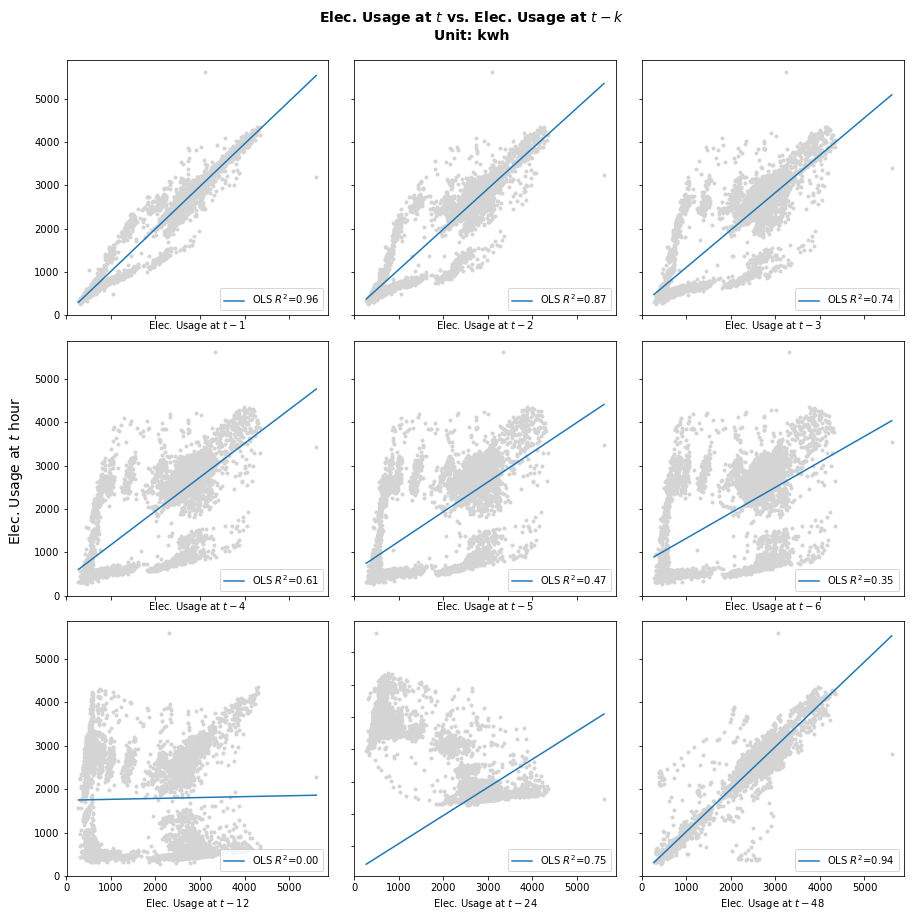

In [22]:
elec_and_weather.drop(elec_and_weather[elec_and_weather.kwh.isnull()].index, inplace=True)

elec_and_weather = elec_and_weather.fillna(method='ffill')

my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [23]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_historical_kwh(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24']
X_train, y_train, X_cross, y_cross, X_test, y_test_30min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

strange thing: for poly kernel some degrees will cause divergence

In [24]:
parameters = {'kernel': ['linear', 'rbf'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='30min')

Testing linear kernel...
Testing rbf kernel...
Done.


In [25]:
search_result['linear']

C,1,10,100,1000
MAE,305.077515,343.038583,399.533146,405.815228
MAPE,11.015692,12.978740,14.723672,14.901875
RMSE,401.429290,447.047749,515.104317,522.643485


In [26]:
search_result['rbf']

MAE                                              MAPE  \
C              1            10           100         1000        1      
gamma                                                                   
0.0001  1416.934404  1396.878560  1188.444949  343.163200  113.248338   
0.0005  1408.356075  1308.402527   416.892258  301.821879  112.543489   
0.001   1397.819953  1199.077385   347.769826  291.766622  111.845681   
0.005   1330.920175   505.239448   308.457699  312.978587  106.313973   
0.01    1279.924312   422.903630   322.293629  326.362644  101.091855   
0.05    1272.960715   577.019473   418.539495  381.108100   98.709287   
0.1     1324.873270   729.054377   482.055867  416.797335  103.524044   
0.5     1402.490092  1220.652978   683.515594  553.720864  111.575436   
auto    1248.833364   509.075043   384.642606  370.475059   96.684989   

                                                 RMSE               \
C             10         100        1000         1            10     
gamma                                                                
0.0001  111.751357  93.030197  11.672022  1470.561168  1449.721208   
0.0005  104.404808  16.052035  11.004838  1461.714433  1358.675418   
0.001    94.121306  11.828868  11.042849  1450.676691  1247.977333   
0.005    20.898779  11.569766  12.813732  1381.846577   629.791091   
0.01     14.308833  12.525378  13.602177  1330.773174   553.576092   
0.05     19.434413  16.480528  14.947916  1327.304477   748.737499   
0.1      25.959585  18.308730  15.612343  1379.712989   934.715223   
0.5      79.966981  24.746993  18.385730  1456.635761  1326.939022   
auto     17.309180  15.198726  14.734764  1302.418554   660.501987   

                                 
C              100         1000  
gamma                            
0.0001  1237.379525  452.671316  
0.0005   531.662386  396.563564  
0.001    458.133090  381.917702  
0.005    398.755122  395.171354  
0.01     409.532222  409.721233  
0.05     525.457297  486.834639  
0.1      608.990937  536.129248  
0.5      885.140165  740.008192  
auto     483.183609  472.022444

** final test **

{'RMSE': 261.77428438611798, 'MAE': 187.94518359746766, 'MAPE': 8.392877963959009}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,140.800824,7.247869,180.283341,113154.983854,107896.787222,-4.646898
2017-05-04,123.959328,6.957019,152.820314,107548.491406,104707.106979,-2.641957
2017-05-05,170.307625,8.363303,243.660992,112773.778906,105290.360330,-6.635779
2017-05-06,341.366676,12.175151,431.576171,122118.200521,105933.467664,-13.253334
2017-05-07,163.291464,7.221049,202.840032,119738.961979,113230.970634,-5.435149


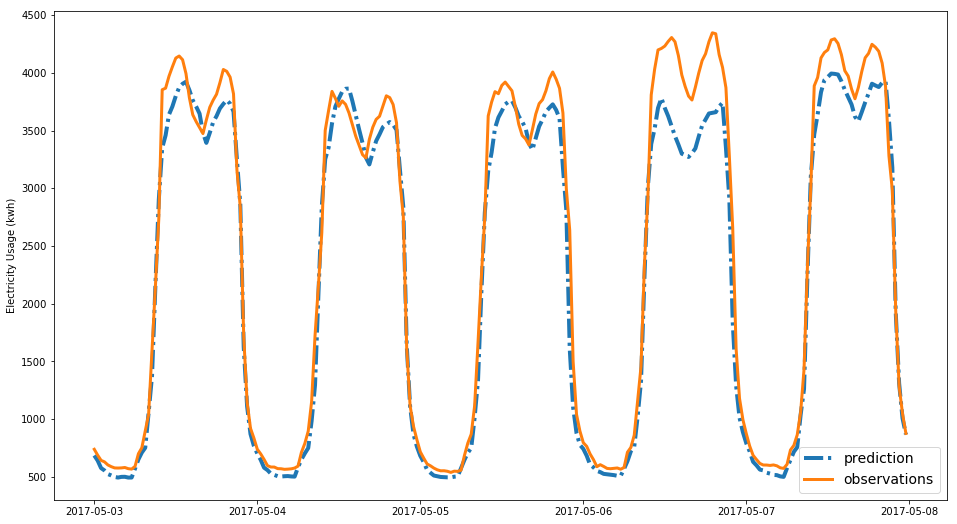

In [27]:
final_model = svm.SVR(kernel='poly', C=500, degree=4).fit(df_X_train_scaled, y_train)
result_30min, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled,  y_test_30min,
                                          test_set_dates, scale='30min')
dv.plot_pred( y_test_30min, result_30min)
df_err

# 2 hours

In [28]:
elec = read_data.elec(elec_data_path, scale='2H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,2192.85,82.0,13.0
2017-01-15 02:00:00,1749.45,77.0,14.0
2017-01-15 04:00:00,1720.95,88.0,13.0
2017-01-15 06:00:00,2202.60,88.0,13.0
2017-01-15 08:00:00,5506.65,88.0,13.0


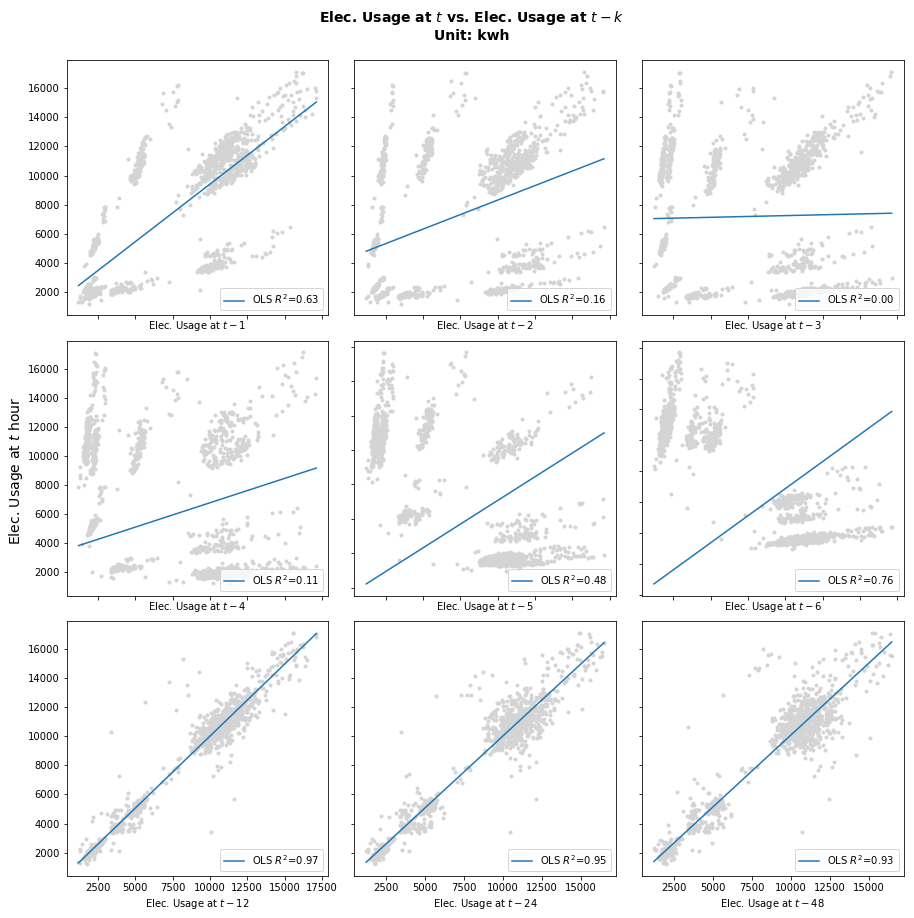

In [29]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [30]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_historical_kwh(elec_and_weather)

drop_col = ['kwh_t-1', 'kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_2h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [31]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [32]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='2H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [33]:
search_result['linear']

C,1,10,100,1000
MAE,3982.187679,2836.846925,2966.612026,3040.080571
MAPE,59.770923,25.277429,26.807616,27.491269
RMSE,4450.578620,3614.261336,3775.962748,3871.466695


In [34]:
search_result['rbf']

MAE                                               MAPE  \
C              1            10           100          1000        1      
gamma                                                                    
0.0001  5522.223967  5519.345310  5490.474651  5201.051204  104.040434   
0.0005  5520.959548  5506.681210  5363.113346  3996.623321  103.996853   
0.001   5519.411451  5491.140118  5208.146882  3005.170745  103.943478   
0.005   5508.241849  5378.282177  4142.423057  2730.072712  103.557811   
0.01    5496.955850  5269.347313  3217.964243  2626.361024  103.166976   
0.05    5465.283820  4957.169923  2577.792127  2389.893590  102.053738   
0.1     5471.138287  5022.102133  2669.451579  2259.021261  102.229667   
0.5     5510.041956  5400.562997  4341.391540  2455.202626  103.475195   
auto    5469.007048  4987.453812  2622.829905  2453.485430  102.189588   

                                                  RMSE               \
C             10          100        1000         1            10     
gamma                                                                 
0.0001  103.941225  102.945504  94.005867  5841.362168  5839.203580   
0.0005  103.504557   98.508132  60.060746  5840.414085  5829.740839   
0.001   102.968213   94.113167  30.805457  5839.254759  5818.203528   
0.005    99.048626   64.003908  24.718115  5830.940892  5736.719338   
0.01     95.082402   38.319130  24.504727  5822.643091  5658.143479   
0.05     88.286511   23.452198  23.014906  5800.611294  5359.538537   
0.1      89.870988   24.642309  21.347671  5805.890208  5422.918414   
0.5      98.231545   59.264906  23.313567  5835.316420  5784.260020   
auto     89.527581   23.952264  23.705734  5802.880669  5379.197221   

                                  
C              100          1000  
gamma                             
0.0001  5817.694348  5584.462353  
0.0005  5725.065938  4466.043250  
0.001   5592.203900  3676.713732  
0.005   4600.987097  3462.139055  
0.01    3791.635670  3312.415792  
0.05    3259.719632  3009.080744  
0.1     3383.993702  2876.252714  
0.5     5046.278768  3144.588826  
auto    3306.207096  3082.375797

In [35]:
search_result['poly']

MAE                                               MAPE  \
C              1            10           100          1000        1      
degree                                                                   
2       5504.994273  5350.393583  4134.514299  2462.663092  103.468705   
3       5513.571076  5432.578901  4736.718413  2141.192938  103.747100   
4       5518.503104  5482.087495  5129.224708  2437.447020  103.913355   
5       5520.587164  5502.964056  5329.679866  3800.092363  103.984253   
6       5521.594742  5513.050212  5427.231738  4707.245962  104.018855   
7       5522.070721  5517.812685  5475.131713  5079.086432  104.035285   

                                                  RMSE               \
C             10          100        1000         1            10     
degree                                                                
2        98.262468   60.597737  24.562121  5828.777128  5717.000965   
3       100.996333   75.158094  17.824531  5834.989995  5776.345129   
4       102.668002   90.965353  22.360995  5838.637617  5812.132258   
5       103.378749   97.308051  52.033182  5840.164529  5827.266696   
6       103.725284  100.771125  71.124470  5840.903346  5834.623798   
7       103.889718  102.429150  86.453186  5841.252045  5838.103775   

                                  
C              100          1000  
degree                            
2       4640.996144  2978.485553  
3       5266.259136  2780.463940  
4       5548.044292  3101.956176  
5       5702.472341  4368.999174  
6       5772.760816  5304.121055  
7       5806.840244  5560.378753

** final test **

{'RMSE': 2787.0975813685468, 'MAE': 2167.7221889339326, 'MAPE': 18.482136406349348}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,2182.427792,17.766172,2873.146328,113154.983854,87412.701362,-22.749579
2017-05-04,2033.276926,17.969397,2625.863421,107548.491406,83871.365660,-22.015303
2017-05-05,2268.572977,20.796070,2802.090143,112773.778906,85550.903185,-24.139366
2017-05-06,2149.860023,18.144647,2769.168479,122118.200521,96319.880245,-21.125696
2017-05-07,2204.473227,17.734395,2858.221978,119738.961979,94537.003355,-21.047417


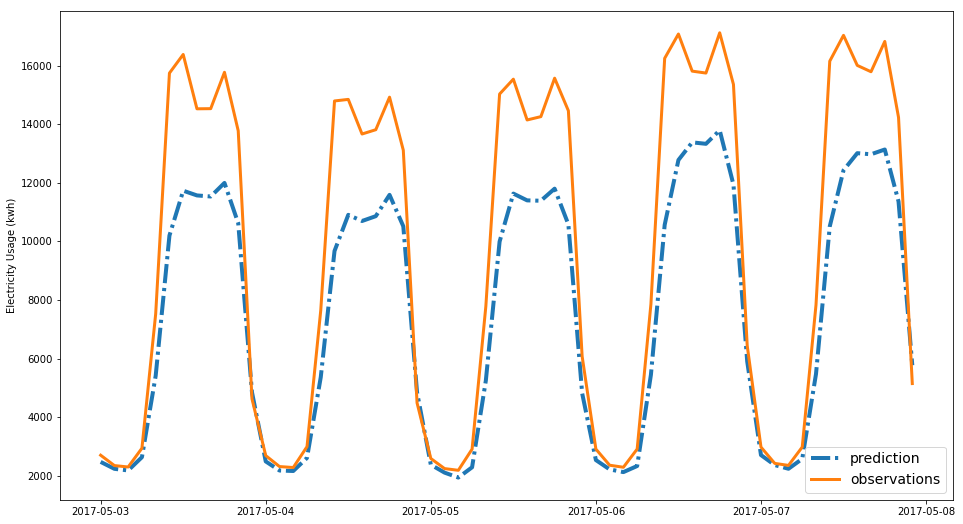

In [36]:
final_model = svm.SVR(kernel='poly', C=1000, degree=3).fit(df_X_train_scaled, y_train)
result_2h, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_2h,
                                          test_set_dates, scale='2H')
dv.plot_pred(y_test_2h, result_2h)
df_err

# 4 hours

In [37]:
elec = read_data.elec(elec_data_path, scale='4H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,3942.30,82.0,13.0
2017-01-15 04:00:00,3923.55,88.0,13.0
2017-01-15 08:00:00,16026.75,88.0,13.0
2017-01-15 12:00:00,21594.00,82.0,14.0
2017-01-15 16:00:00,22262.85,82.0,14.0


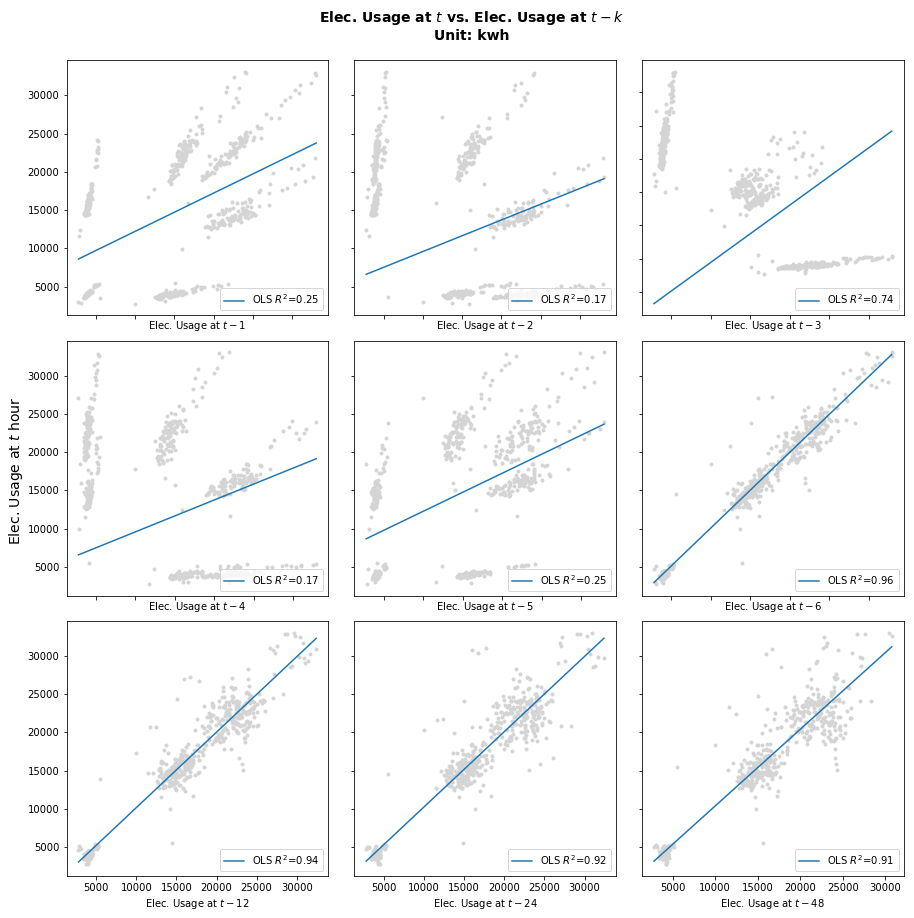

In [38]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [39]:
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-1', 'kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48', 1, 2, 3,
           5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23]
X_train, y_train, X_cross, y_cross, X_test, y_test_4h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [40]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='4H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [41]:
search_result['linear']

C,1,10,100,1000
MAE,9495.454470,5841.087776,6109.826344,6660.176811
MAPE,85.646056,24.488399,25.595734,27.568408
RMSE,10151.530547,7604.125056,8046.217397,8810.044091


In [42]:
search_result['rbf']

MAE                                                 MAPE  \
C               1             10            100           1000       1      
gamma                                                                       
0.0001  10232.735447  10231.597675  10220.211163  10084.668075  92.692048   
0.0005  10232.234468  10226.585786  10166.913213   9502.227663  92.685874   
0.001   10231.618613  10220.420862  10087.251661   8767.945280  92.678257   
0.005   10227.085641  10171.955727   9558.905274   5787.514633  92.621185   
0.01    10222.310038  10110.663840   8985.641652   5670.082848  92.558765   
0.05    10203.963556   9905.269133   7028.173007   5113.683891  92.322840   
0.1     10202.718445   9890.154569   7020.351650   4958.553948  92.308265   
0.5     10225.396978  10139.315681   9246.039533   5823.785263  92.561081   
auto    10202.718445   9890.154569   7020.351650   4958.553948  92.308265   

                                                 RMSE                \
C            10         100        1000          1             10     
gamma                                                                 
0.0001  92.678053  92.538002  91.364806  10966.693104  10965.396363   
0.0005  92.616285  91.947363  85.687792  10966.122066  10959.684339   
0.001   92.540039  91.380342  78.136618  10965.419983  10952.658498   
0.005   91.997050  86.127119  24.798768  10960.248271  10897.980891   
0.01    91.521736  80.143390  23.489729  10954.790138  10830.505557   
0.05    89.337771  53.319669  22.931614  10934.031612  10602.525192   
0.1     89.224760  50.233304  22.790163  10932.775501  10587.660355   
0.5     91.534542  79.772645  27.845488  10958.490937  10866.772607   
auto    89.224760  50.233304  22.790163  10932.775501  10587.660355   

                                    
C               100           1000  
gamma                               
0.0001  10952.422006  10802.021747  
0.0005  10892.294887  10158.873189  
0.001   10804.853118   9360.558411  
0.005   10220.878005   7485.190955  
0.01     9595.846860   7439.684976  
0.05     7642.595421   6555.880531  
0.1      7725.571097   6184.817026  
0.5      9946.244850   7111.203678  
auto     7725.571097   6184.817026

In [43]:
search_result['poly']

MAE                                               MAPE  \
C               1             10           100          1000       1      
degree                                                                    
2       10211.359181   9991.940816  7899.063184  4859.756896  92.388211   
3       10206.887648   9926.856159  7416.408055  4782.311570  92.375561   
4       10215.857661  10026.366682  8296.480535  4523.069264  92.469533   
5       10214.573792  10022.939637  8471.357173  4933.472764  92.510071   
6       10216.261066  10051.560091  8748.433647  5264.163649  92.554342   
7       10214.472478  10060.318497  8887.746711  5696.151291  92.588068   

                                                 RMSE                \
C            10         100        1000          1             10     
degree                                                                
2       89.906913  62.482490  24.070220  10941.331392  10688.847854   
3       89.944208  60.012833  19.849716  10936.693300  10621.009675   
4       90.834976  70.670850  19.003103  10946.975139  10733.735672   
5       91.128911  73.770347  22.561447  10945.763487  10729.856577   
6       91.442870  76.908735  27.841275  10947.939005  10762.927951   
7       91.521993  78.341894  34.298998  10946.134824  10771.448287   

                                  
C              100          1000  
degree                            
2       8432.623915  5895.371691  
3       7932.911993  6003.991781  
4       8829.135092  5614.479467  
5       9012.966336  6038.882082  
6       9312.301722  6213.786107  
7       9460.418541  6528.347715

{'RMSE': 5508.2586896010253, 'MAE': 4469.402099785527, 'MAPE': 18.801073249242396}


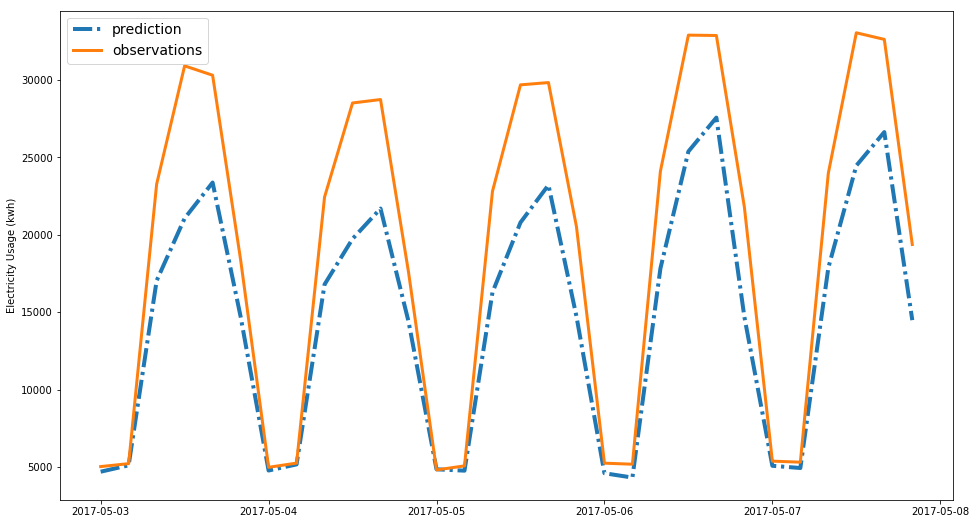

In [44]:
final_model = svm.SVR(kernel='poly', C=1000, degree=4).fit(df_X_train_scaled, y_train)
result_4h, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_4h,
                                          test_set_dates, scale='4H')
dv.plot_pred(y_test_4h, result_4h)

# 15 min

In [45]:
elec_data_path = './elec_data/hac.xlsx'
weather_data_path = './weather_data/weather_data_20170101-20170507_Shenzhen.csv'

elec = read_data.elec(elec_data_path)
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')
elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,352.20,82.0,13.0
2017-01-15 00:15:00,309.75,NaN,NaN
2017-01-15 00:30:00,301.95,NaN,NaN
2017-01-15 00:45:00,281.25,NaN,NaN
2017-01-15 01:00:00,244.95,77.0,14.0


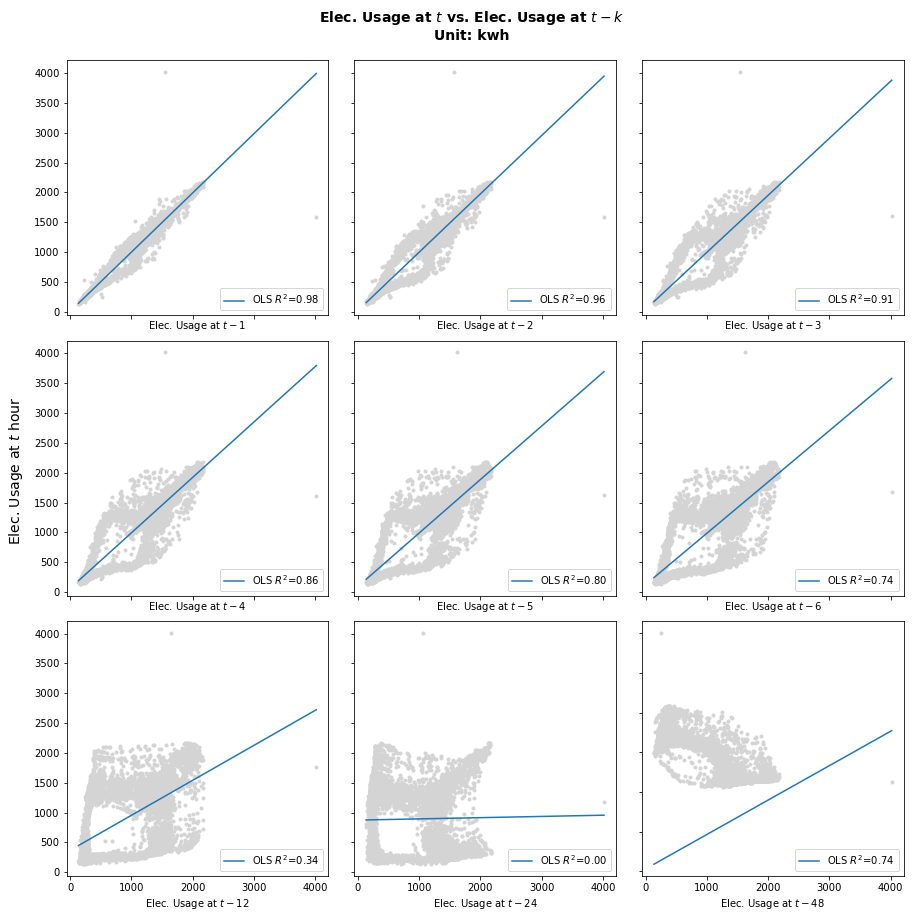

In [46]:
elec_and_weather = elec_and_weather.fillna(method='ffill')
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [47]:
holidays=['2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '4/3/2017', '4/4/2017', '5/1/2017']
workdays=['4/1/2017']
split_date = ['1/17/2017', '4/27/2017', '4/28/2017', '5/2/2017', '5/3/2017', '5/7/2017']
cross_set_dates = ['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02']
test_set_dates = ['2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07']

In [48]:
elec_and_weather['kwh_t-96'] = elec_and_weather['kwh'].shift(96)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_15min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head(5)

,hum,tempm,kwh_t-1,kwh_t-96,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,if_holiday
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-01-17 00:00:00,82.0,15.0,315.75,302.25,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:15:00,82.0,15.0,309.15,268.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:30:00,82.0,15.0,297.30,249.90,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:45:00,82.0,15.0,275.25,252.45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 01:00:00,94.0,14.0,263.40,246.90,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='15min')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [50]:
search_result['linear']

C,1,10,100,1000
MAE,694.855604,790.122875,797.254939,798.554522
MAPE,43.613541,50.900163,51.553297,51.681083
RMSE,909.593690,1025.759276,1033.981767,1035.449447


In [51]:
search_result['rbf']

MAE                                            MAPE  \
C             1           10          100         1000        1      
gamma                                                                
0.0001  705.343120  666.500246  370.416178  454.015907  112.998105   
0.0005  688.439140  507.087622  395.790502  680.863579  110.068435   
0.001   668.361955  374.205889  446.039323  735.192111  106.508023   
0.005   544.989309  378.044379  632.527466  757.838637   79.588065   
0.01    458.909364  395.246475  678.925334  733.762062   55.191143   
0.05    451.254613  372.487161  599.883348  632.484197   44.954981   
0.1     536.240574  382.156233  535.992230  571.013080   66.305225   
0.5     678.104995  499.957531  495.701669  496.447255  103.677217   
auto    415.684015  384.974750  643.006396  661.738838   37.118754   

                                                RMSE                          \
C             10         100        1000        1           10          100    
gamma                                                                          
0.0001  106.150994  30.122094  29.687754  732.474670  692.755576  460.864166   
0.0005   70.228256  26.350143  42.443353  715.157631  540.499424  515.276336   
0.001    31.199399  29.303653  45.839197  694.646685  462.329402  581.370709   
0.005    25.460640  39.361930  47.072041  574.455913  491.050801  829.710143   
0.01     26.783234  42.045480  45.369256  508.524322  511.959411  890.292024   
0.05     26.322462  39.089040  39.094487  530.044508  476.710583  785.399709   
0.1      26.493755  35.772188  36.252392  590.149391  493.150020  700.763784   
0.5      39.003505  33.059024  33.566926  709.251277  632.647144  647.034593   
auto     27.051676  40.853774  40.655076  504.169798  493.210430  843.297382   

                    
C             1000  
gamma               
0.0001  592.246292  
0.0005  892.536606  
0.001   961.987612  
0.005   993.496294  
0.01    967.545974  
0.05    845.087048  
0.1     756.967980  
0.5     647.273631  
auto    885.116286

In [52]:
search_result['poly']

MAE                                           MAPE             \
C             1           10          100         1000       1          10     
degree                                                                         
2       491.429756  324.554288  434.374455  560.533580  57.574451  25.157939   
3       474.116140  316.292593  525.726540  672.987331  56.604895  21.591581   
4       503.846539  317.259869  525.348926  649.465761  64.591304  21.739577   
5       520.928235  326.696683  533.985335  634.395793  70.014530  21.806833   
6       537.698885  332.254287  532.788603  621.691842  74.780688  21.762004   
7       551.841494  337.476188  526.551749  614.384145  78.915525  21.909923   

                                    RMSE                                      
C            100        1000        1           10          100         1000  
degree                                                                        
2       33.220183  59.304894  549.450710  401.032778  551.905105  688.440291  
3       33.569665  40.848176  526.267351  407.350534  700.611589  910.213396  
4       34.152259  39.505186  547.651132  408.433363  699.192765  879.624586  
5       34.122115  38.723632  558.819337  423.947375  713.605232  860.957672  
6       33.687351  38.058372  571.862775  433.856895  713.526301  844.091088  
7       32.972828  37.598272  583.162249  442.394113  707.243810  835.295595

{'RMSE': 490.25990220607719, 'MAE': 401.5386894809278, 'MAPE': 33.852745603093034}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,400.128335,35.342010,486.036534,113154.983854,86014.478717,-23.985249
2017-05-04,362.428964,34.203374,432.440704,107548.491406,83268.855804,-22.575524
2017-05-05,385.608555,30.861402,472.592989,112773.778906,82612.087044,-26.745306
2017-05-06,440.584921,33.313236,544.416285,122118.200521,88695.448765,-27.369181
2017-05-07,418.942673,35.543707,508.727982,119738.961979,91833.118775,-23.305566


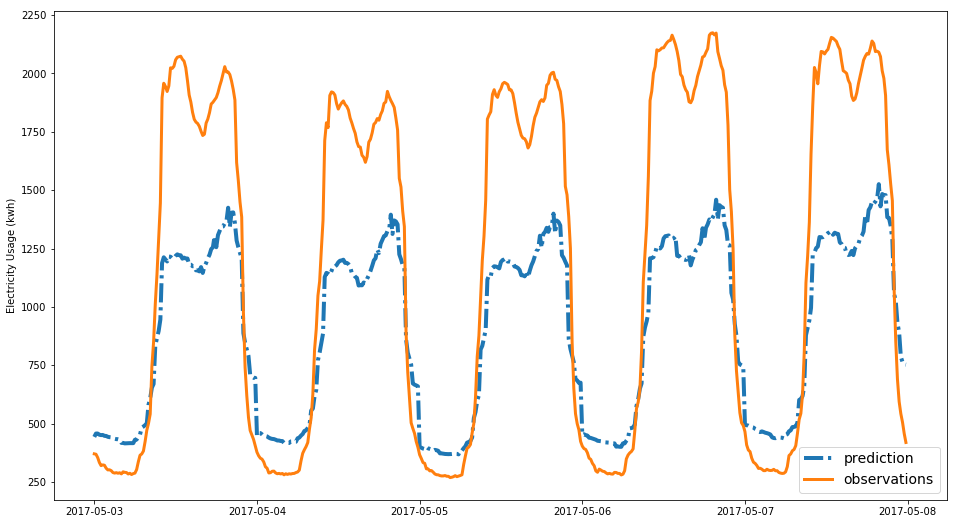

In [53]:
final_model = svm.SVR(kernel='rbf', C=10, gamma=0.001).fit(df_X_train_scaled, y_train)
result_15min, df_err_15min = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_15min,
                                          test_set_dates, scale='15min')
dv.plot_pred(y_test_15min, result_15min)
df_err_15min

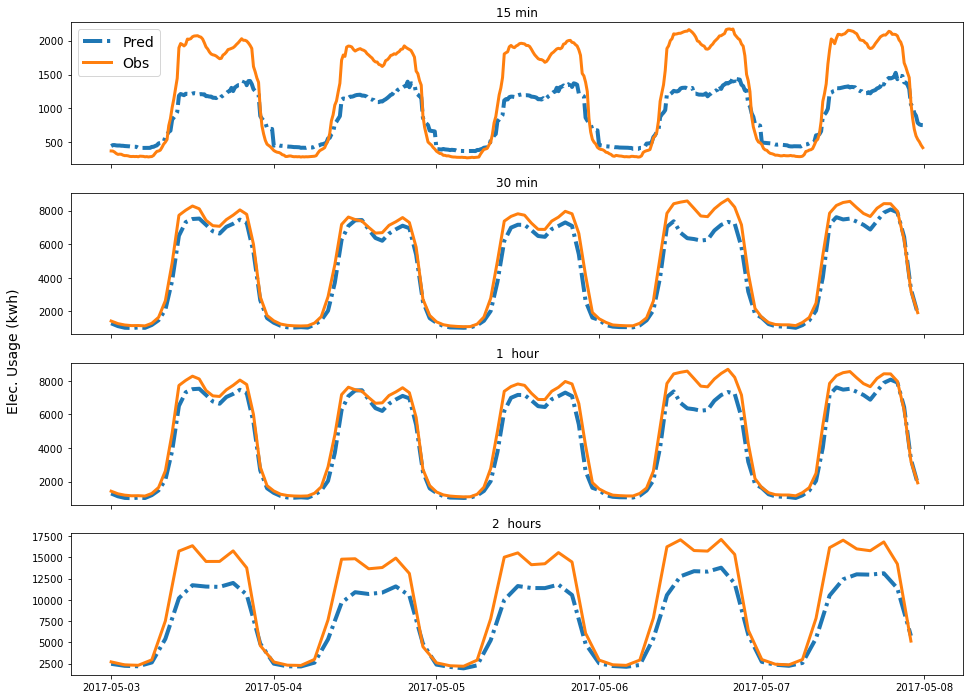

In [54]:
dv.plot_multiscale_result(result_15min, y_test_15min, result_30min, y_test_30min, result_1h, y_test_1h, result_2h, y_test_2h)

# TEST
train set: '4/29/2017', '5/3/2017'  
cross set: '5/4/2017', '5/5/2017'  
test set: '5/6/2017', '5/7/2017'  

** 1 hour **

In [55]:
elec_data_path = './elec_data/hac.xlsx'
weather_data_path = './weather_data/weather_data_20170101-20170507_Shenzhen.csv'

elec = read_data.elec(elec_data_path, scale='H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='4/29/2017', endDate='5/7/2017')
elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-04-29 00:00:00,1427.675000,78.0,21.0
2017-04-29 01:00:00,1329.054427,78.0,21.0
2017-04-29 02:00:00,1190.921094,78.0,21.0
2017-04-29 03:00:00,1127.383333,83.0,20.0
2017-04-29 04:00:00,1103.349479,83.0,20.0


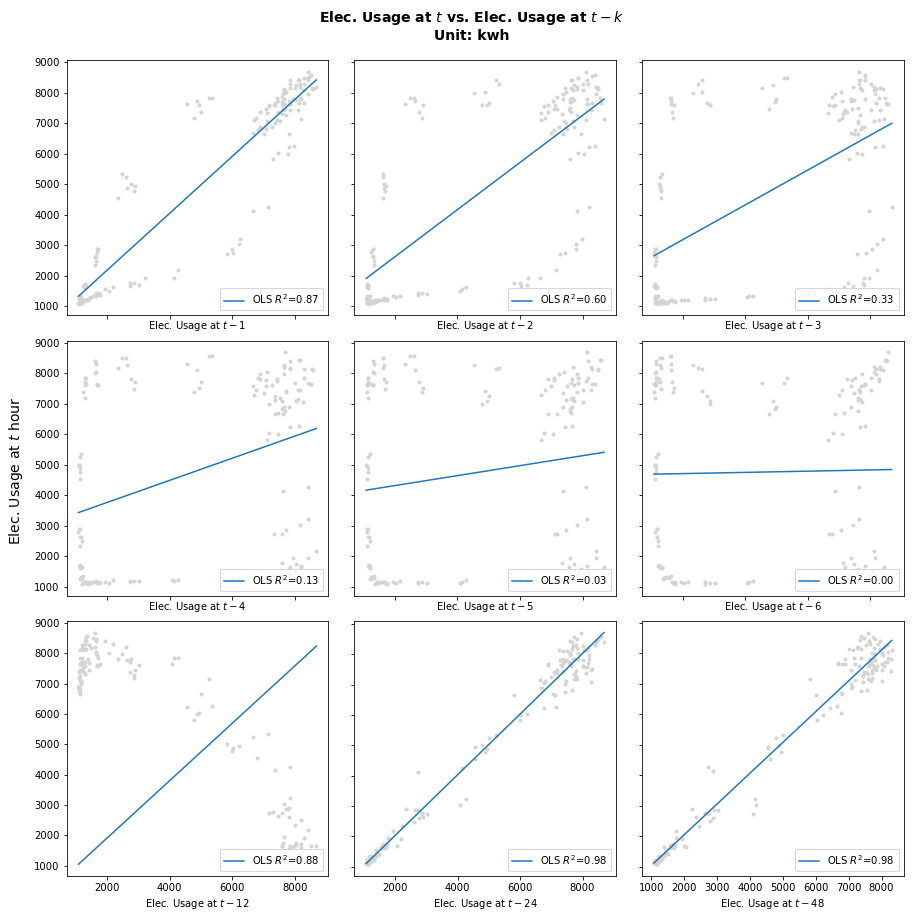

In [56]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather.dropna())

In [57]:
holidays=['5/1/2017']
split_date = ['4/29/2017', '5/3/2017', '5/4/2017', '5/5/2017', '5/6/2017', '5/7/2017']
cross_set_dates = ['5/4/2017', '5/5/2017']
test_set_dates = ['5/6/2017', '5/7/2017']

In [58]:
my_svr.add_if_holiday(elec_and_weather, holidays)
my_svr.add_hour_of_day(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12',]
X_train, y_train, X_cross, y_cross, X_test, y_test_1h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head()

,hum,tempm,kwh_t-1,kwh_t-24,kwh_t-48,if_holiday,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-05-01 00:00:00,73.0,23.0,2051.004948,1412.358073,1427.675000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-01 01:00:00,73.0,23.0,1499.320573,1172.045573,1329.054427,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-01 02:00:00,83.0,22.0,1309.454167,1087.796094,1190.921094,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-01 03:00:00,73.0,23.0,1213.503906,1081.391406,1127.383333,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2017-05-01 04:00:00,83.0,22.0,1120.733594,1075.700260,1103.349479,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [60]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [61]:
search_result['linear']

C,1,10,100,1000
MAE,2445.243935,622.672968,239.644877,185.394545
MAPE,129.650838,20.909316,8.388354,4.030905
RMSE,2704.604517,717.612161,364.596688,288.646688


In [62]:
search_result['rbf']

MAE                                               MAPE  \
C              1            10           100          1000        1      
gamma                                                                    
0.0001  2666.025148  2665.637497  2661.759468  2622.826740  141.385891   
0.0005  2665.857147  2663.957138  2644.920624  2450.848893  141.376980   
0.001   2665.656514  2661.949779  2624.744139  2238.365488  141.366361   
0.005   2664.378656  2649.149861  2494.582910   932.157602  141.299528   
0.01    2663.408829  2639.420291  2394.097921   489.713748  141.250487   
0.05    2663.254724  2637.890114  2380.013438   518.653580  141.259314   
0.1     2664.173448  2647.097769  2474.125596   917.636368  141.307448   
0.5     2665.510914  2660.484502  2609.142392  2024.090932  141.358687   
auto    2662.774600  2633.065361  2329.362979   468.938627  141.229470   

                                                   RMSE               \
C             10          100         1000         1            10     
gamma                                                                  
0.0001  141.365305  141.159361  139.091565  2944.498626  2944.076546   
0.0005  141.276175  140.266134  129.962368  2944.315843  2942.248375   
0.001   141.169934  139.198083  118.923316  2944.097865  2940.067594   
0.005   140.500438  132.385444   41.430175  2942.720077  2926.268949   
0.01    140.008355  127.293378   14.056872  2941.696696  2916.005044   
0.05    140.097336  128.260915   17.071389  2941.755696  2916.614307   
0.1     140.579777  133.194375   46.625164  2942.747099  2926.549349   
0.5     141.092820  138.388206  112.224907  2943.944965  2938.533862   
auto    139.797631  125.134817   13.564298  2941.174651  2910.777895   

                                  
C              100          1000  
gamma                             
0.0001  2939.854264  2897.482750  
0.0005  2921.538139  2710.853646  
0.001   2899.630035  2484.123379  
0.005   2759.557616  1000.663028  
0.01    2653.908195   614.916789  
0.05    2662.134546   668.733789  
0.1     2763.513878  1111.753203  
0.5     2883.818179  2355.015718  
auto    2601.159545   618.195184

In [63]:
search_result['poly']

MAE                                               MAPE  \
C              1            10           100          1000        1      
degree                                                                   
2       2664.252984  2647.915145  2484.464617  1097.158495  141.324989   
3       2664.035243  2645.720706  2460.785243   693.996404  141.304541   
4       2664.383021  2649.202725  2496.043931  1017.370675  141.320651   
5       2664.572027  2651.092097  2514.861873  1164.414384  141.328178   
6       2664.748134  2652.853671  2532.525876  1321.988918  141.335717   
7       2664.894002  2654.312807  2547.161068  1463.513488  141.342005   

                                                  RMSE               \
C             10          100        1000         1            10     
degree                                                                
2       140.756293  135.069703  66.691434  2942.999755  2929.105212   
3       140.551048  132.938887  32.895297  2942.643458  2925.518033   
4       140.712362  134.573984  54.270273  2942.986352  2928.950246   
5       140.787597  135.323585  61.102117  2943.156361  2930.648807   
6       140.863031  136.081674  69.593622  2943.322477  2932.310184   
7       140.925951  136.714479  76.903180  2943.461174  2933.697547   

                                  
C              100          1000  
degree                            
2       2791.983389  1349.482094  
3       2753.649834   772.498145  
4       2788.293075  1156.226282  
5       2805.113245  1314.102234  
6       2821.744782  1495.209459  
7       2835.654866  1648.588226

{'RMSE': 455.93545757869339, 'MAE': 325.5544828965937, 'MAPE': 5.779879628227804}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-06,402.306727,7.088160,547.397674,122118.200521,112494.771760,-7.880421
2017-05-07,248.802239,4.471599,340.749277,119738.961979,114684.439942,-4.221284


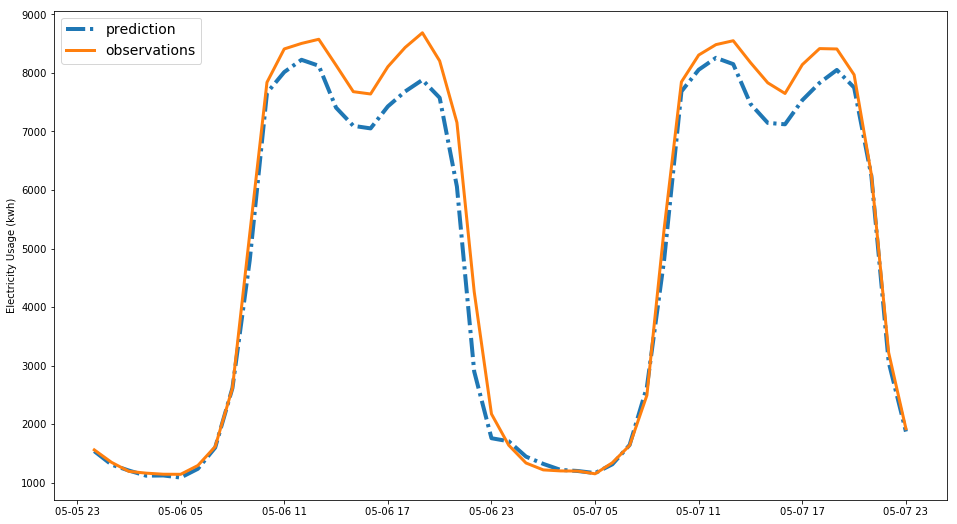

In [64]:
model = svm.SVR(kernel='linear', C=1000).fit(df_X_train_scaled, y_train)
result_1h, df_err = my_svr.predict_many_days(model, scaler, df_X_test_scaled, y_test_1h,
                                          test_set_dates, scale='H')
dv.plot_pred(y_test_1h, result_1h)
df_err

** half hour **

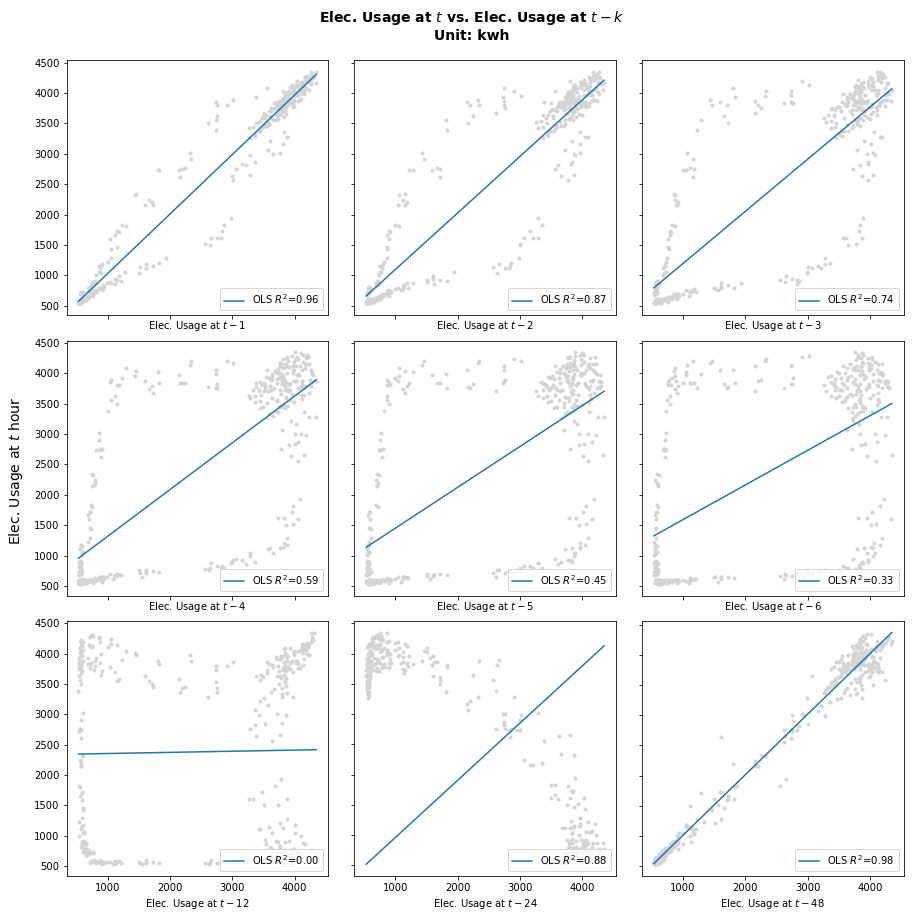

In [65]:
elec = read_data.elec(elec_data_path, scale='30min')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='4/29/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])

elec_and_weather.drop(elec_and_weather[elec_and_weather.kwh.isnull()].index, inplace=True)

elec_and_weather = elec_and_weather.fillna(method='ffill')

my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [66]:
my_svr.add_if_holiday(elec_and_weather, holidays)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_historical_kwh(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24']
X_train, y_train, X_cross, y_cross, X_test, y_test_30min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='30min')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [67]:
search_result['rbf']

MAE                                               MAPE  \
C              1            10           100          1000        1      
gamma                                                                    
0.0001  1333.577586  1332.863950  1325.711290  1253.831826  144.997988   
0.0005  1333.267797  1329.762289  1294.473255   915.841424  144.963243   
0.001   1332.896578  1326.039054  1257.196952   511.160517  144.921748   
0.005   1330.490213  1301.783530  1003.098199   164.183023  144.657535   
0.01    1328.578056  1282.830803   794.028214   138.124129  144.457482   
0.05    1327.526150  1273.325135   727.564955   240.575141  144.441335   
0.1     1329.356180  1291.456420   920.550326   320.781845  144.643702   
0.5     1332.428690  1321.396657  1212.046723   740.577762  144.886219   
auto    1326.843479  1266.269652   639.157472   215.096134  144.341184   

                                                   RMSE               \
C             10          100         1000         1            10     
gamma                                                                  
0.0001  144.917801  144.114042  136.981737  1493.724623  1492.927227   
0.0005  144.569910  140.828725  104.725335  1493.378869  1489.466033   
0.001   144.153687  137.331550   43.922428  1492.965446  1485.321128   
0.005   141.583354  112.761458    8.687947  1490.315777  1459.203425   
0.01    139.777379   90.992714    6.352796  1488.272856  1439.838956   
0.05    139.812492   86.510270   13.334124  1487.741809  1435.935073   
0.1     141.476277  112.779522   23.345611  1489.761612  1453.939407   
0.5     143.796287  138.649792   63.827666  1492.552299  1481.142692   
auto    138.834469   71.949848   10.634696  1486.831189  1426.821686   

                                  
C              100          1000  
gamma                             
0.0001  1484.937519  1410.131102  
0.0005  1451.401790  1067.729161  
0.001   1413.729213   551.999487  
0.005   1152.170047   229.196393  
0.01     928.129338   211.231229  
0.05     874.367974   339.985031  
0.1     1131.030667   435.426350  
0.5     1405.837989   890.515658  
auto     741.922755   307.936624

In [68]:
search_result['linear']

C,1,10,100,1000
MAE,904.475195,139.017600,104.852916,98.729511
MAPE,103.713983,9.234530,5.346955,4.999271
RMSE,1057.116871,194.299411,166.258516,152.041167


In [69]:
search_result['poly']

MAE                                              MAPE  \
C              1            10           100         1000        1      
degree                                                                  
2       1328.647078  1284.527560   880.658875  206.628389  144.650446   
3       1328.614558  1283.713024   846.135190  177.523185  144.604193   
4       1329.431681  1291.570738   921.038643  210.553583  144.680286   
5       1329.964506  1296.669444   966.945906  232.882687  144.724754   
6       1330.438962  1301.394296  1008.517049  259.259638  144.765389   
7       1330.834619  1305.424826  1044.890342  282.153411  144.799090   

                                                  RMSE               \
C             10          100        1000         1            10     
degree                                                                
2       141.418860  110.835764  15.981571  1489.534093  1451.150283   
3       140.888649  103.839009   7.419394  1489.214897  1447.338197   
4       141.659157  112.290188   9.770295  1490.021277  1455.469920   
5       142.149696  115.923000  10.133145  1490.515354  1460.679406   
6       142.706554  118.930304  11.471252  1490.963211  1466.106700   
7       143.250822  121.657269  12.658935  1491.336558  1471.164058   

                                 
C              100         1000  
degree                           
2       1112.249029  263.824124  
3       1044.134047  265.359417  
4       1130.299773  306.022772  
5       1170.075735  341.131771  
6       1204.887728  375.676143  
7       1236.377241  404.645577

{'RMSE': 192.39798256881789, 'MAE': 144.07466176798948, 'MAPE': 6.010954020801315}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-06,197.352186,8.015901,246.107356,122118.200521,112799.086335,-7.631225
2017-05-07,90.797137,4.006007,116.039376,119738.961979,117778.091891,-1.637621


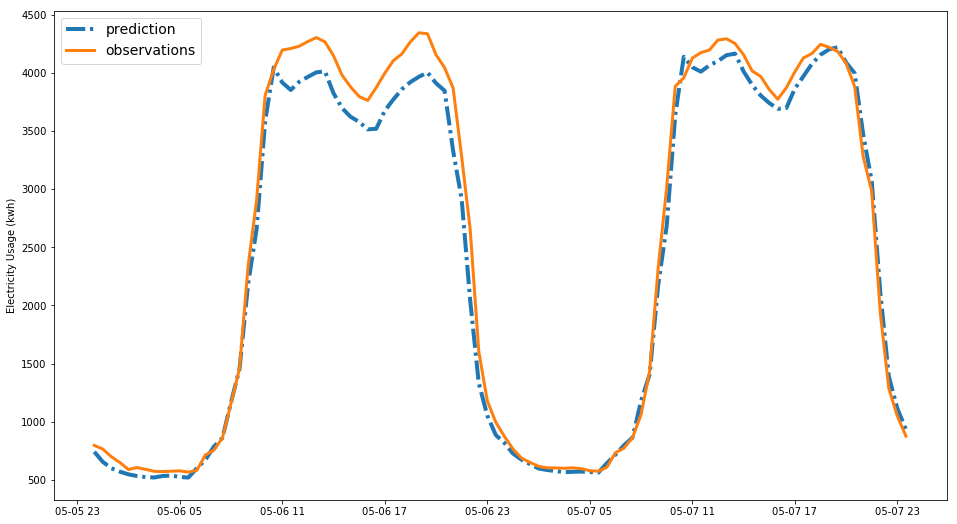

In [70]:
final_model = svm.SVR(kernel='linear', C=70).fit(df_X_train_scaled, y_train)
result_30min, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled,  y_test_30min,
                                          test_set_dates, scale='30min')
dv.plot_pred( y_test_30min, result_30min)
df_err

** 2 hours **

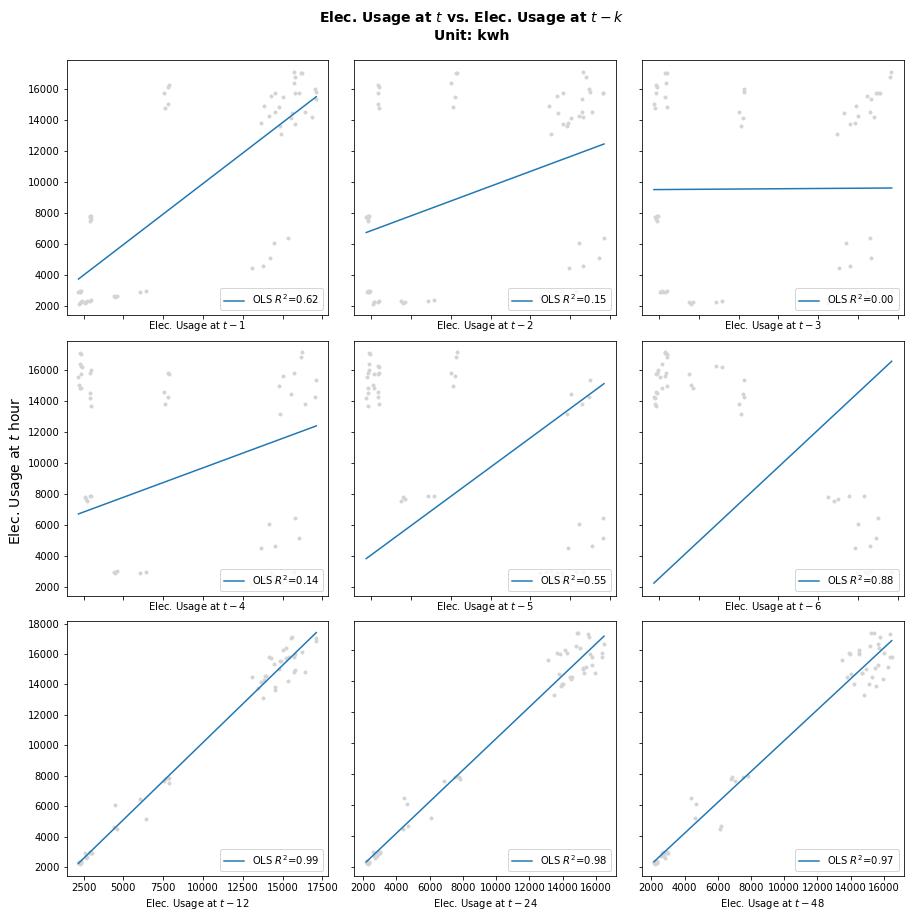

In [71]:
elec = read_data.elec(elec_data_path, scale='2H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='4/29/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])

elec_and_weather.drop(elec_and_weather[elec_and_weather.kwh.isnull()].index, inplace=True)

elec_and_weather = elec_and_weather.fillna(method='ffill')

my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [72]:
my_svr.add_if_holiday(elec_and_weather, holidays)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_historical_kwh(elec_and_weather)

drop_col = ['kwh_t-1', 'kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_2h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='2H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [73]:
search_result['linear']

C,1,10,100,1000
MAE,5316.386301,5172.816698,3538.636816,2550.691556
MAPE,134.079550,130.392321,86.638259,36.566887
RMSE,5721.554431,5568.395394,3882.698576,3246.720264


In [74]:
search_result['rbf']

MAE                                               MAPE  \
C              1            10           100          1000        1      
gamma                                                                    
0.0001  5332.133297  5332.105039  5331.822454  5328.995897  134.483141   
0.0005  5332.120863  5331.980697  5330.578865  5316.543185  134.482823   
0.001   5332.105598  5331.828044  5329.051822  5301.221780  134.482434   
0.005   5331.993948  5330.711407  5317.872103  5188.076325  134.479630   
0.01    5331.877715  5329.548785  5306.215882  5068.457654  134.476801   
0.05    5331.489892  5325.669130  5267.277241  4664.706206  134.468737   
0.1     5331.484266  5325.613355  5266.768518  4665.057391  134.469679   
0.5     5331.852572  5329.297063  5303.669835  5039.605267  134.478062   
auto    5331.554221  5326.312559  5273.725054  4730.421022  134.469757   

                                                   RMSE               \
C             10          100         1000         1            10     
gamma                                                                  
0.0001  134.482417  134.475178  134.402770  5738.388375  5738.358166   
0.0005  134.479237  134.443375  134.084237  5738.375095  5738.225357   
0.001   134.475345  134.404439  133.693367  5738.358816  5738.062571   
0.005   134.447298  134.123578  130.845240  5738.240700  5736.881287   
0.01    134.419007  133.839805  127.919480  5738.119773  5735.671747   
0.05    134.338326  133.029235  119.427160  5737.747055  5731.943439   
0.1     134.347762  133.124873  120.522216  5737.765258  5732.126206   
0.5     134.431604  133.965211  129.097205  5738.133771  5735.812043   
auto    134.348530  133.131577  120.479555  5737.801754  5732.490461   

                                  
C              100          1000  
gamma                             
0.0001  5738.056068  5735.034451  
0.0005  5736.727823  5721.736903  
0.001   5735.099508  5705.408021  
0.005   5723.274659  5585.952187  
0.01    5711.152294  5462.010374  
0.05    5673.756376  5077.301399  
0.1     5675.658339  5104.495815  
0.5     5712.586877  5479.324322  
auto    5679.230101  5132.052975

In [75]:
search_result['poly']

MAE                                               MAPE  \
C              1            10           100          1000        1      
degree                                                                   
2       5331.948957  5330.261615  5313.385237  5144.324055  134.480356   
3       5332.046797  5331.240016  5323.169543  5242.196456  134.481653   
4       5332.094609  5331.718151  5327.952718  5290.212370  134.482602   
5       5332.115615  5331.928215  5330.053880  5311.276853  134.482935   
6       5332.125716  5332.029230  5331.064234  5321.400767  134.483093   
7       5332.130679  5332.078858  5331.560598  5326.372446  134.483160   

                                                   RMSE               \
C             10          100         1000         1            10     
degree                                                                 
2       134.454571  134.196690  131.615316  5738.233971  5736.814247   
3       134.467532  134.326284  132.909269  5738.311931  5737.593738   
4       134.477026  134.421259  133.862612  5738.356976  5738.044182   
5       134.480360  134.454607  134.196744  5738.374968  5738.224093   
6       134.481936  134.470364  134.354534  5738.383550  5738.309912   
7       134.482606  134.477070  134.421668  5738.387531  5738.349719   

                                  
C              100          1000  
degree                            
2       5722.629690  5582.110639  
3       5730.413190  5658.754059  
4       5734.917163  5703.741520  
5       5736.715729  5721.671165  
6       5737.573700  5730.228179  
7       5737.971676  5734.198025

{'RMSE': 2366.1089931203073, 'MAE': 1631.0308542992905, 'MAPE': 23.80121362382934}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-06,1719.817689,28.543138,2325.739680,122118.200521,114984.759517,-5.841423
2017-05-07,1542.244020,19.059289,2405.801005,119738.961979,117017.377090,-2.272932


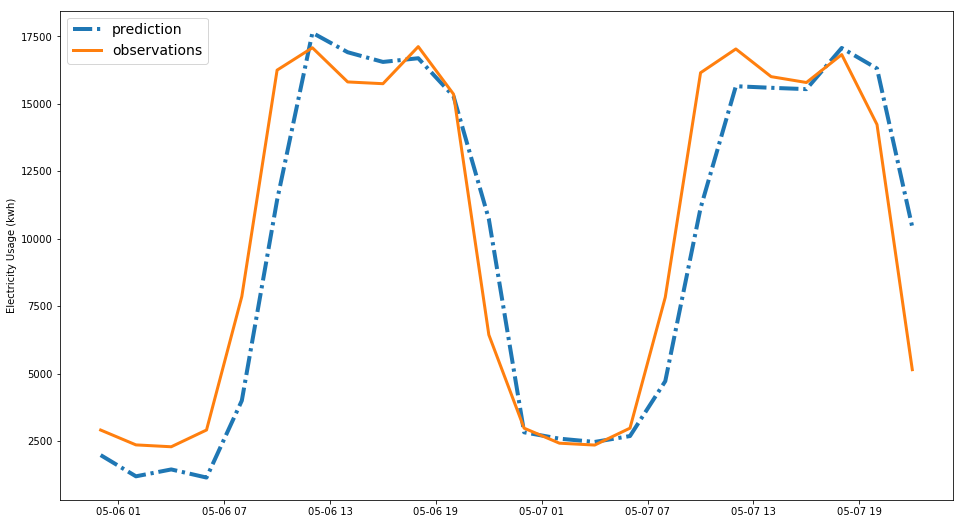

In [76]:
final_model = svm.SVR(kernel='linear', C=700 ).fit(df_X_train_scaled, y_train)
result_2h, df_err = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled,  y_test_2h,
                                          test_set_dates, scale='2H')
dv.plot_pred( y_test_2h, result_2h)
df_err

# 15min

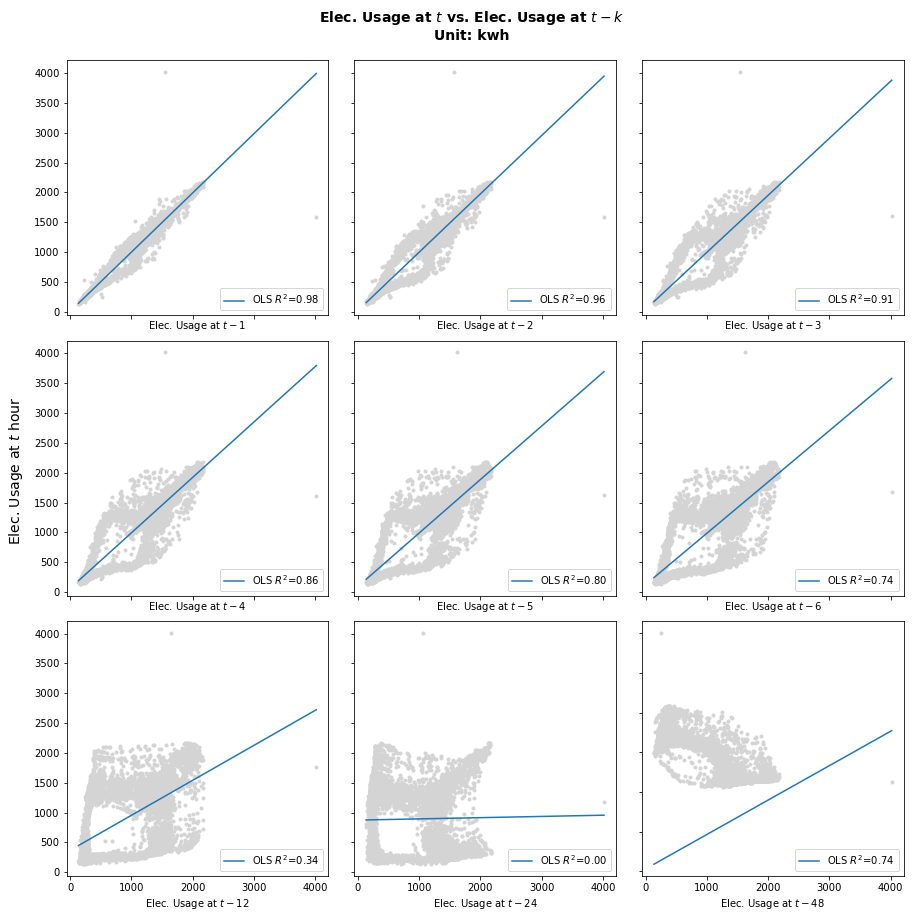

In [77]:
elec_data_path = './elec_data/hac.xlsx'
weather_data_path = './weather_data/weather_data_20170101-20170507_Shenzhen.csv'

elec = read_data.elec(elec_data_path)
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')
elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])

elec_and_weather = elec_and_weather.fillna(method='ffill')
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [78]:
holidays=['5/1/2017']
split_date = ['4/29/2017', '5/3/2017', '5/4/2017', '5/5/2017', '5/6/2017', '5/7/2017']
cross_set_dates = ['5/4/2017', '5/5/2017']
test_set_dates = ['5/6/2017', '5/7/2017']

elec_and_weather['kwh_t-96'] = elec_and_weather['kwh'].shift(96)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_15min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='15min')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [79]:
search_result['linear']

C,1,10,100,1000
MAE,289.145804,379.639068,632.266936,703.670794
MAPE,24.344814,26.707070,40.002465,44.841189
RMSE,357.437599,486.354902,823.903910,914.457321


In [80]:
search_result['rbf']

MAE                                            MAPE  \
C             1           10          100         1000        1      
gamma                                                                
0.0001  667.798772  666.052875  648.529321  477.270055  150.240214   
0.0005  667.040065  658.470396  573.285311  287.757484  150.106559   
0.001   666.133459  649.339858  484.525390  291.219222  149.946516   
0.005   660.264863  590.834893  279.455579  323.644079  148.913570   
0.01    655.617736  545.434534  264.309418  345.002554  147.959917   
0.05    653.365182  524.108040  200.662614  273.615749  147.448798   
0.1     658.042643  569.976374  215.080265  253.977082  148.492267   
0.5     665.525178  643.293506  459.187915  449.252334  149.928366   
auto    651.587273  506.655380  216.804019  306.694906  147.042615   

                                                  RMSE              \
C             10          100         1000        1           10     
gamma                                                                
0.0001  149.932063  146.327214  107.529098  764.117378  762.441132   
0.0005  148.590298  127.718886   24.225171  763.389979  755.158887   
0.001   146.514474  110.006372   22.640786  762.519210  744.729330   
0.005   132.216392   24.050066   23.149889  756.899435  674.360077   
0.01    123.087858   20.010832   25.391268  751.957128  626.772961   
0.05    122.574571   20.160903   25.032720  749.350293  618.337727   
0.1     133.104116   28.185195   28.189565  754.602903  671.001116   
0.5     143.864564   79.204458   68.679065  762.204777  732.932615   
auto    117.647912   18.700208   25.465316  747.322162  594.818492   

                                
C             100         1000  
gamma                           
0.0001  743.794776  549.815786  
0.0005  652.616418  355.963286  
0.001   561.038085  367.142630  
0.005   344.859771  415.659348  
0.01    338.508711  440.153626  
0.05    249.262323  342.300167  
0.1     255.836964  312.262612  
0.5     498.428877  500.273737  
auto    275.492782  387.972453

In [81]:
search_result['poly']

MAE                                            MAPE  \
C             1           10          100         1000        1      
degree                                                               
2       656.035026  550.642370   79.357588   75.393109  148.214541   
3       655.704996  546.711442  124.794718  164.709225  148.064343   
4       657.736109  566.249863  147.399399  174.288549  148.518748   
5       658.987105  578.513228  174.694293  187.119630  148.782368   
6       660.120444  589.627323  201.834803  196.928638  148.975418   
7       661.061185  598.795552  229.349452  206.915071  149.136663   

                                                RMSE                          \
C             10         100        1000        1           10          100    
degree                                                                         
2       131.832950  13.216488  10.190887  753.049656  662.700361  111.731994   
3       128.387646  11.319520  13.974534  752.391842  647.640679  169.482582   
4       131.707406  15.694162  14.554768  754.680431  665.415302  188.846012   
5       133.176533  19.449302  15.402271  756.034745  674.356551  216.841993   
6       134.937368  24.440798  16.238750  757.094493  684.200415  241.503201   
7       136.554032  30.109466  17.178057  757.979279  693.000705  265.922247   

                    
C             1000  
degree              
2       109.072969  
3       220.792188  
4       235.742646  
5       250.600098  
6       261.816094  
7       272.063155

{'RMSE': 215.22800472926093, 'MAE': 171.01871671888944, 'MAPE': 16.41954002250007}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-06,189.966911,19.592416,231.497095,122118.200521,111802.351998,-8.447429
2017-05-07,152.070522,13.246664,197.624095,119738.961979,110899.148719,-7.382570


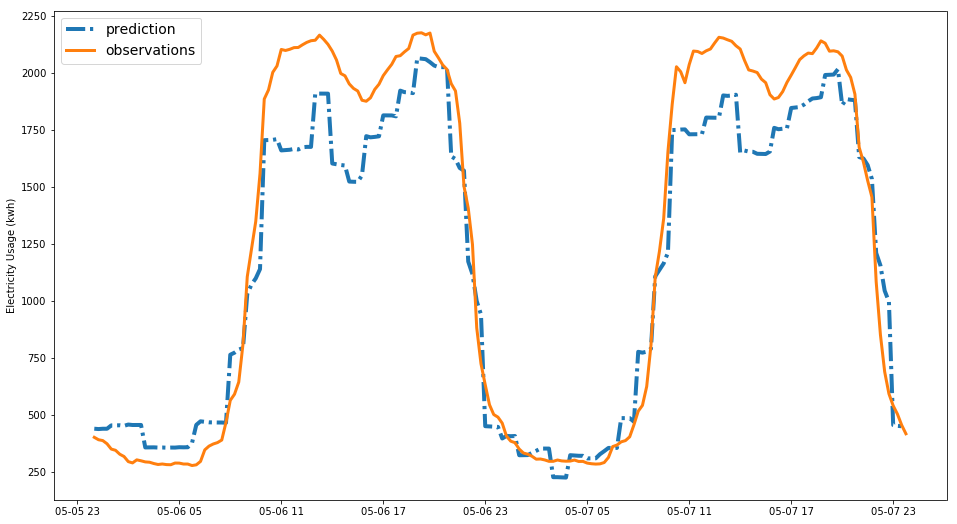

In [82]:
final_model = svm.SVR(kernel='poly', C=1000, degree=2).fit(df_X_train_scaled, y_train)
result_15min, df_err_15min = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_15min,
                                          test_set_dates, scale='15min')
dv.plot_pred(y_test_15min, result_15min)
df_err_15min

#  plot result

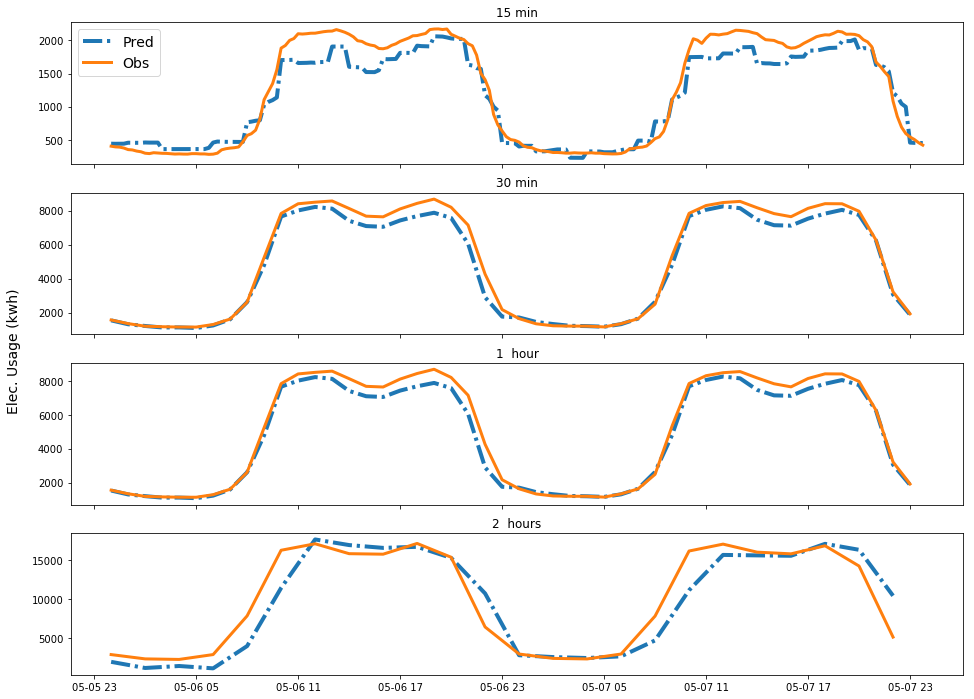

In [83]:
    f, ax = plt.subplots(4, sharex=True, figsize=(16, 12))
    l1 = ax[0].plot(y_test_15min.index, result_15min, linestyle='-.', lw=4)
    l2 = ax[0].plot(y_test_15min.index, y_test_15min, lw=3)
    ax[0].set_title('15 min')
    ax[0].legend((l1[0], l2[0]), ('Pred', 'Obs'),
                 loc='upper left', fontsize=14)

    ax[1].plot(result_1h, linestyle='-.', lw=4)
    ax[1].plot(y_test_1h, lw=3)
    ax[1].set_title('30 min')

    ax[2].plot(result_1h, linestyle='-.', lw=4)
    ax[2].plot(y_test_1h, lw=3)
    ax[2].set_title('1  hour')

    ax[3].plot(result_2h, linestyle='-.', lw=4)
    ax[3].plot(y_test_2h, lw=3)
    ax[3].set_title('2  hours')

    f.text(0.07, 0.5, 'Elec. Usage (kwh)', va='center',
           rotation='vertical', fontsize=14)